<a href="https://colab.research.google.com/github/Jianfeng0Liu/Color-Difference_Visually-Impaired-People/blob/main/Color_Difference_Visually_Impaired_People.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This is for google colab, which used for training now.
from google.colab import drive
drive.mount('/content/drive')    

Mounted at /content/drive


#Packages#

In [2]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
from keras import backend as K
from keras import layers, Model, Input
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random

#GPU Training Setting (Selected)#
Setting to use GPU for Accelerating training.  
  
CPU training is also available, the program of this module is not required when using CPU training.

In [3]:
# Setting to use GPU for training

import os
import tensorflow as tf
from keras.backend import set_session

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Assign which GPU for training
config = tf.compat.v1.ConfigProto()
config.allow_soft_placement=True 
config.gpu_options.per_process_gpu_memory_fraction = 0.4 # 40% GPU memory for training
config.gpu_options.allow_growth=True   # GPU memory not fully occupied during initialization, allocated on demand
sess = tf.compat.v1.Session(config = config)
set_session(sess)

#1. Preliminary Try#
Based on the preliminary study code (Given by Prof. Damien).

**Changing Parameters:**  
Layer: 10  
Unit(nn): 256  
Epochs: 1000  
Learning Rate: 1e-4

**Result**  
Around Train_loss=0.03 and Validation_loss=0.04

Epoch 1/1000
80/80 [==============================] - 9s 12ms/step - loss: 0.6690 - val_loss: 0.4341
Epoch 2/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.4106 - val_loss: 0.3608
Epoch 3/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.3920 - val_loss: 0.4178
Epoch 4/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.3722 - val_loss: 0.3690
Epoch 5/1000
80/80 [==============================] - 1s 6ms/step - loss: 0.3721 - val_loss: 0.3600
Epoch 6/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.3452 - val_loss: 0.3954
Epoch 7/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.3532 - val_loss: 0.4108
Epoch 8/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.3171 - val_loss: 0.3110
Epoch 9/1000
80/80 [==============================] - 1s 7ms/step - loss: 0.3173 - val_loss: 0.3648
Epoch 10/1000
80/80 [==============================] - 1s 6ms/step - loss: 0.3061 - val_loss: 0.319

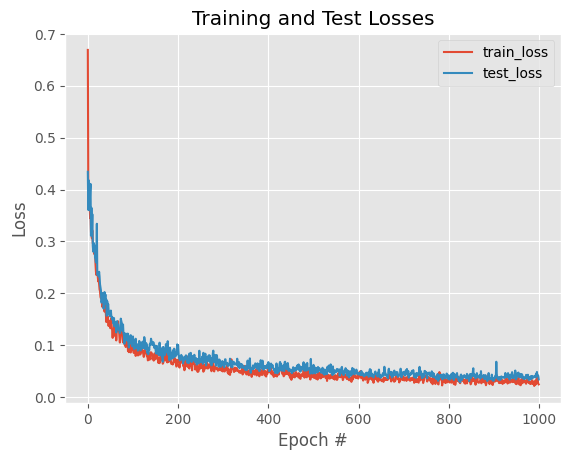

In [ ]:
bs=8
vnoise=1

# Train/ Val sets 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_set = train_df.values
val_set = val_df.values

train_set = np.asarray(train_set).astype(np.float32)
val_set = np.asarray(val_set).astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]

def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
datagen_val = ImageDataGenerator()

train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)

def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

nn=256  # units 200 to 256


# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-4))    # Learning rate changes 1e-5 to 1e-4

# Training
nb_epochs=1000;    # epochs change to 1000
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


# Plot the curves
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

The Training Loss is around 0.03,  the Validation Loss is around 0.04, which is far more below the naive prediction 0.11.

#**-- ABANDONED --**: Predict probability distribution over the 3 classes#
**This part is actually classification based on most selected result, which is not to predict the distribution**  
  
**3 classes:**   
"Cannot see any difference" - 0  [1,0,0] (one-hot encoding).  
"Just noticeable difference(JND)" - 1  [0,1,0].    
"Clearly see a difference" - 2  [0,0,1].  


1.Use the "cross entropy" loss function between the prediction and the ground truth.  
$H(p, q) = -\sum_{i=1}^{C} p_i \log(q_i)$  
(Input the Euclidean distance + the outputs of the twin networks to the last layers)  
**--> Question: Ground truth <-> Average color difference assessment? Rounding?**  
--> In this trail, the ground truth will be chosen as the most selected results by paticipants in the experiment.  **--> Question: Is it reasonable?**  

**--> Reply: What we want to predict for each tested pair is the probability aver the three classes, so that we can say, for example : "for this pair, 70% of
the observers would say JND, 25% would say 'see nothing' and 5% would say 'clear difference'. we have to train with real ground truth values, not integers. We have to learn to predict the true values, which are float numbers. And there is no problem for a Deep network to predict float numbers, even
for a classification problem.**

2.Add a softmax activation function in the last layer. Try to add a "Temperature" in this softmax.



Epoch 1/500
80/80 [==============================] - 10s 83ms/step - loss: 0.8158 - val_loss: 0.6156
Epoch 2/500
80/80 [==============================] - 5s 64ms/step - loss: 0.7167 - val_loss: 0.5977
Epoch 3/500
80/80 [==============================] - 5s 62ms/step - loss: 0.6546 - val_loss: 0.5902
Epoch 4/500
80/80 [==============================] - 6s 81ms/step - loss: 0.6266 - val_loss: 0.5187
Epoch 5/500
80/80 [==============================] - 5s 62ms/step - loss: 0.6133 - val_loss: 0.4934
Epoch 6/500
80/80 [==============================] - 6s 70ms/step - loss: 0.5741 - val_loss: 0.5526
Epoch 7/500
80/80 [==============================] - 6s 74ms/step - loss: 0.5589 - val_loss: 0.4466
Epoch 8/500
80/80 [==============================] - 5s 62ms/step - loss: 0.5387 - val_loss: 0.4624
Epoch 9/500
80/80 [==============================] - 7s 82ms/step - loss: 0.5078 - val_loss: 0.4515
Epoch 10/500
80/80 [==============================] - 5s 63ms/step - loss: 0.5079 - val_loss: 0.412

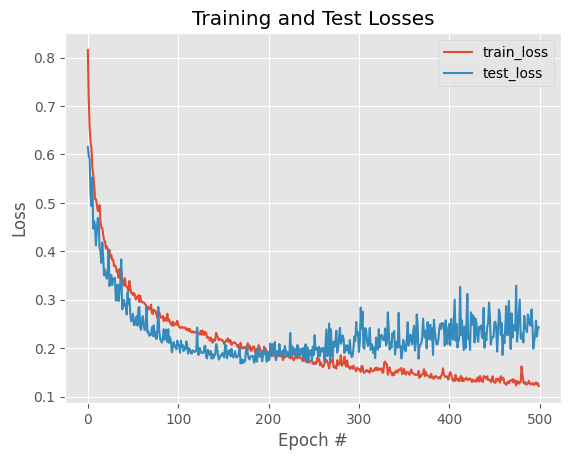

In [ ]:
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy

bs=8    # batch_size  
vnoise=0    # the amount of noise to be added to training data
nn=512    # training units number set as 256
nb_epochs=500;    # training epochs change to 1000


##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/all_BVG.csv', header=0)    # note the data is from all_BVG.csv file

# Calculate the most selected data by participants
results_cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'];
results_subset = data_df.loc[:, results_cols]    # select columns of participants evaluation result
subset_mode = results_subset.mode(axis=1)    # get mode along result subset - rows axis
data_df['most_common'] = subset_mode.iloc[:, 0]    # extract most common element in each row

# Data splitting(8:2)
data_df = data_df.drop(columns = ['C1', 'C2']+results_cols)    # drop columns (color information and results of participants)
train_df, val_df = train_test_split(data_df, test_size=0.2, random_state=42)    # split the data   
train_set = train_df.values
val_set = val_df.values

# Get the Lab data (X) and most selected data (Y)
train_set = np.asarray(train_set).astype(np.float32)    # convert to ndarray, then convert all the components to float32
X_train = train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train = train_set[:,6].astype(int)    # convert the float type to int type
Y_train = to_categorical(Y_train)    # one-hot encoding

val_set = np.asarray(val_set).astype(np.float32)
X_val = val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val = val_set[:,6].astype(int)
Y_val = to_categorical(Y_val)


##### Data Augument ##### 
# Add noise
def add_noise(vec):
    deviation = vnoise*random.random()    # generate a random deviation: standard deviation of the normal distribution
    noise = np.random.normal(0, deviation, vec.shape)    # generate random noise based on deviation
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)    # apply add_noise() function to each input for trianing
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)    # generate batches of noisy training data


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Creates sequential neural network model.
net = Sequential()  
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the siamese neural network
In = Input(shape=(6,1,1))
[Lab1, Lab2] = layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)

dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
dist = layers.Reshape((1,), name='output')(dist)  # reshape the output to be 2D
pred = Dense(3, activation='softmax')(dist)    # add a softmax layer, output a probability distribution over the 3 classes.

siamese = Model(inputs = In, outputs = pred)    # create the model: input is the Lab pairs and output is the class

# Loss and optimizer
siamese.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=1e-4))    # The categorical_crossentropy loss and the Learning rate set as 5e-5 (Adam)

# Training
H=siamese.fit(X_train, Y_train, batch_size = bs, epochs=nb_epochs, validation_data=(X_val, Y_val))
siamese.evaluate(X_val, Y_val)    


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

#2. Predict Probability Distribution over the 3 Classes#  
1.Use the "cross entropy" loss function between the prediction and the ground truth.  
$H(p, q) = -\sum_{i=1}^{C} p_i \log(q_i)$  
(Input the Euclidean distance + the outputs of the twin networks to the last layers)  
  
2.Add a softmax activation function in the last layer. Try to add a "Temperature" in this softmax.

##Dataset Processment **--> Run this! <--**##

In [4]:
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/all_BVG.csv', header=0)    # note the data is from all_BVG.csv file

# Calculate the most selected data by participants
results_cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'];
results_subset = data_df.loc[:, results_cols]    # select columns of participants evaluation result

# count occurrences in each row, and make new columns
def count_occurrences(row,element):
    count = 0
    for value in row:
        if value == element:
            count += 1
    return count/20

data_df['0occurrences'] = results_subset.apply(count_occurrences, args=(0,), axis=1)
data_df['1occurrences'] = results_subset.apply(count_occurrences, args=(1,), axis=1)
data_df['2occurrences'] = results_subset.apply(count_occurrences, args=(2,), axis=1)

# Data splitting(7:3)
data_df = data_df.drop(columns = ['C1', 'C2']+results_cols)    # drop columns (color information and results of participants)
train_df, val_df = train_test_split(data_df, test_size=0.3, random_state=42)    # split the data   
train_set = train_df.values
val_set = val_df.values

# Get the Lab data (X) and probability distribution (Y)
train_set = np.asarray(train_set).astype(np.float32)    # convert to ndarray, then convert all the components to float32
X_train = train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train = train_set[:,6:9]    # probability distribution columns
Y_train = Y_train.reshape(-1,3)

val_set = np.asarray(val_set).astype(np.float32)
X_val = val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val = val_set[:,6:9]
Y_val = Y_val.reshape(-1,3)
print(Y_val)  # example: output to see the possibility distribution for validation set

[[0.   0.05 0.95]
 [0.   0.   1.  ]
 [0.1  0.55 0.35]
 [0.   0.   1.  ]
 [0.   0.2  0.8 ]
 [0.   0.05 0.95]
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   0.1  0.9 ]
 [0.   0.05 0.95]
 [0.   0.1  0.9 ]
 [0.05 0.05 0.9 ]
 [0.   0.   1.  ]
 [0.   0.25 0.75]
 [0.   0.   1.  ]
 [0.   0.15 0.85]
 [0.05 0.05 0.9 ]
 [0.   0.   1.  ]
 [0.   0.1  0.9 ]
 [0.   0.1  0.9 ]
 [0.   0.45 0.55]
 [0.   0.3  0.7 ]
 [0.05 0.4  0.55]
 [0.   0.   1.  ]
 [0.1  0.35 0.55]
 [0.   0.3  0.7 ]
 [0.   0.   1.  ]
 [0.1  0.35 0.55]
 [0.   0.   1.  ]
 [0.   0.1  0.9 ]
 [0.05 0.   0.95]
 [0.35 0.5  0.15]
 [0.   0.   1.  ]
 [0.   0.05 0.95]
 [0.05 0.   0.95]
 [0.   0.05 0.95]
 [0.   0.   1.  ]
 [0.   0.   1.  ]
 [0.   0.05 0.95]
 [0.   0.   1.  ]
 [0.05 0.2  0.75]
 [0.   0.05 0.95]
 [0.   0.1  0.9 ]
 [0.05 0.05 0.9 ]
 [0.   0.2  0.8 ]
 [0.1  0.35 0.55]
 [0.   0.   1.  ]
 [0.05 0.2  0.75]
 [0.   0.   1.  ]
 [0.   0.15 0.85]
 [0.05 0.   0.95]
 [0.2  0.75 0.05]
 [0.   0.   1.  ]
 [0.05 0.   0.95]
 [0.05 0.   0.95]
 [0.   0.0

##2.1 Without Temperature in Softmax: Softmax only based the euclidean distance##

**Result**  
Around Training_loss = 0.38, validation_loss = 0.38 (500 Epochs)

Epoch 1/500
70/70 [==============================] - 7s 14ms/step - loss: 1.0549 - val_loss: 1.0402
Epoch 2/500
70/70 [==============================] - 1s 8ms/step - loss: 1.0334 - val_loss: 1.0203
Epoch 3/500
70/70 [==============================] - 1s 8ms/step - loss: 1.0166 - val_loss: 1.0025
Epoch 4/500
70/70 [==============================] - 1s 12ms/step - loss: 0.9990 - val_loss: 0.9854
Epoch 5/500
70/70 [==============================] - 1s 12ms/step - loss: 0.9815 - val_loss: 0.9649
Epoch 6/500
70/70 [==============================] - 1s 11ms/step - loss: 0.9590 - val_loss: 0.9478
Epoch 7/500
70/70 [==============================] - 1s 15ms/step - loss: 0.9390 - val_loss: 0.9233
Epoch 8/500
70/70 [==============================] - 1s 10ms/step - loss: 0.9141 - val_loss: 0.8934
Epoch 9/500
70/70 [==============================] - 1s 8ms/step - loss: 0.8864 - val_loss: 0.8638
Epoch 10/500
70/70 [==============================] - 1s 9ms/step - loss: 0.8583 - val_loss: 0.8317
Epo

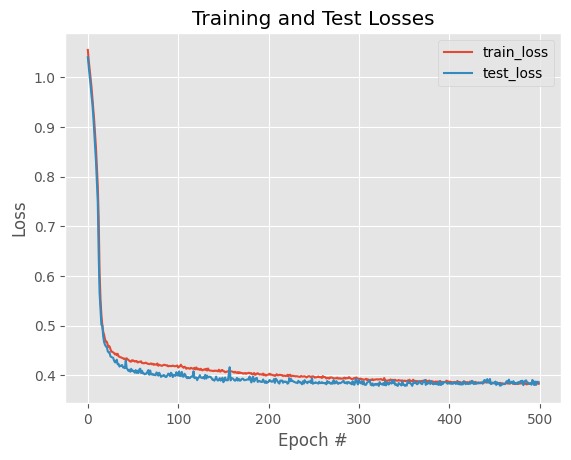

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=512    # training units number
nb_epochs=500;    # training epochs

##### Data Augument ##### 
# Add noise
def add_noise(vec):
    deviation = vnoise*random.random()    # generate a random deviation: standard deviation of the normal distribution
    noise = np.random.normal(0, deviation, vec.shape)    # generate random noise based on deviation
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)    # apply add_noise() function to each input for trianing
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)    # generate batches of noisy training data

##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Creates sequential neural network model.
net = Sequential()  
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the siamese neural network
In = Input(shape=(6,1,1))
[Lab1, Lab2] = layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)


dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
dist = layers.Reshape((1,), name='output')(dist)  # reshape the output to be 2D

# ------------------------------------------------------------!!!!!!!!!! softmax only based the euclidean distance
pred = Dense(3, activation='softmax')(dist)    # add a softmax layer, output a probability distribution over the 3 classes.
# ------------------------------------------------------------!!!!!!!!!!

siamese = Model(inputs = In, outputs = pred)    # create the model: input is the Lab pairs and output is the class

# Loss and optimizer
siamese.compile(loss = categorical_crossentropy, optimizer=Adam(learning_rate=1e-4))    # The categorical_crossentropy loss and the Learning rate set as 1e-4 (Adam)

# Training
H=siamese.fit(X_train, Y_train, batch_size = bs, epochs=nb_epochs, validation_data=(X_val, Y_val))
siamese.evaluate(X_val, Y_val)    


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

##2.2 Without Temperature in Softmax: Softmax based the euclidean distance and the output of Siamese Neural Network##

**Result**  
Around Training_loss = 0.38, validation_loss = 0.40

Epoch 1/1000
70/70 [==============================] - 9s 14ms/step - loss: 1.0322 - val_loss: 0.9992
Epoch 2/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.9072 - val_loss: 0.7348
Epoch 3/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.6831 - val_loss: 0.6107
Epoch 4/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.6404 - val_loss: 0.6026
Epoch 5/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.6309 - val_loss: 0.5979
Epoch 6/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.6244 - val_loss: 0.5931
Epoch 7/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.6212 - val_loss: 0.5877
Epoch 8/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.6134 - val_loss: 0.5828
Epoch 9/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.6035 - val_loss: 0.5774
Epoch 10/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.5953 - val_loss: 0

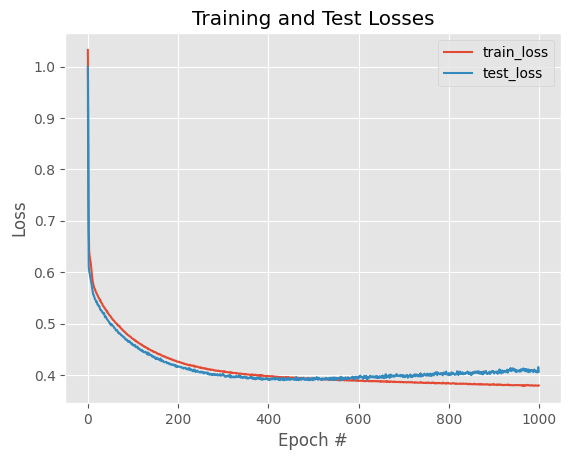

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=512    # training units number
nb_epochs=1000;    # training epochs

##### Data Augument ##### 
# Add noise
def add_noise(vec):
    deviation = vnoise*random.random()    # generate a random deviation: standard deviation of the normal distribution
    noise = np.random.normal(0, deviation, vec.shape)    # generate random noise based on deviation
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)    # apply add_noise() function to each input for trianing
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)    # generate batches of noisy training data


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

# Creates sequential neural network model.
net = Sequential()  
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the siamese neural network
In = Input(shape=(6,1,1))
[Lab1, Lab2] = layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)


dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
dist = layers.Reshape((1,), name='output')(dist)  # reshape the output to be 2D

# ------------------------------------------------------------!!!!!!!!!!
# normalize the dist
dist_normalized = normalize(dist, 0, 2)

# normalize the Lab1 and Lab2
L_min, L_max = 0, 100
a_min, a_max = -128, 127
b_min, b_max = -128, 127

Lab1_flat = Flatten()(Lab1)
Lab2_flat = Flatten()(Lab2)

Lab1_normalized = K.stack([
    normalize(Lab1_flat[:,0], L_min, L_max),
    normalize(Lab1_flat[:,1], a_min, a_max),
    normalize(Lab1_flat[:,2], b_min, b_max)
], axis=-1)

Lab2_normalized = K.stack([
    normalize(Lab2_flat[:,0], L_min, L_max),
    normalize(Lab2_flat[:,1], a_min, a_max),
    normalize(Lab2_flat[:,2], b_min, b_max)
], axis=-1)


# concatenate x1, x2 and dist tensors as the input of softmax layer
con_value = K.concatenate([dist_normalized, Lab1_normalized, Lab2_normalized], axis=-1)

# concatenate x1, x2 and dist tensors as the input of softmax layer
pred = Dense(3, activation='softmax')(con_value)    # add a softmax layer, output a probability distribution over the 3 classes.
# ------------------------------------------------------------!!!!!!!!!!

siamese = Model(inputs = In, outputs = pred)    # create the model: input is the Lab pairs and output is the class

# Loss and optimizer
siamese.compile(loss = categorical_crossentropy, optimizer=Adam(learning_rate=1e-5))    # The categorical_crossentropy loss and the Learning rate set as 1e-4 (Adam)

# Training
H=siamese.fit(X_train, Y_train, batch_size = bs, epochs=nb_epochs, validation_data=(X_val, Y_val))
siamese.evaluate(X_val, Y_val)    


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()


##2.3 Add the Temperature in Softmax （3000 Epochs）##
The formula of softmax is:  
$\large P_i=\frac{e^{y_i}}{\sum_{k=1}^n e^{y_k}}$  

After add temperature is:  
$\large P_i=\frac{e^{\frac{y_i}T}}{\sum_{k=1}^n e^{\frac{y_k}T}}$  
A higher temperature (above 1) makes the model less confident, meaning that the probability distribution becomes more flat.
 

流式输出内容被截断，只能显示最后 5000 行内容。
70/70 [==============================] - 1s 9ms/step - loss: 0.3869 - val_loss: 0.3993
Epoch 503/3000
70/70 [==============================] - 1s 9ms/step - loss: 0.3870 - val_loss: 0.3927
Epoch 504/3000
70/70 [==============================] - 1s 9ms/step - loss: 0.3881 - val_loss: 0.3937
Epoch 505/3000
70/70 [==============================] - 1s 10ms/step - loss: 0.3887 - val_loss: 0.3987
Epoch 506/3000
70/70 [==============================] - 1s 9ms/step - loss: 0.3892 - val_loss: 0.3913
Epoch 507/3000
70/70 [==============================] - 1s 9ms/step - loss: 0.3866 - val_loss: 0.3886
Epoch 508/3000
70/70 [==============================] - 1s 9ms/step - loss: 0.3857 - val_loss: 0.3895
Epoch 509/3000
70/70 [==============================] - 1s 9ms/step - loss: 0.3857 - val_loss: 0.3930
Epoch 510/3000
70/70 [==============================] - 1s 10ms/step - loss: 0.3871 - val_loss: 0.3948
Epoch 511/3000
70/70 [==============================] - 1s 12ms/step

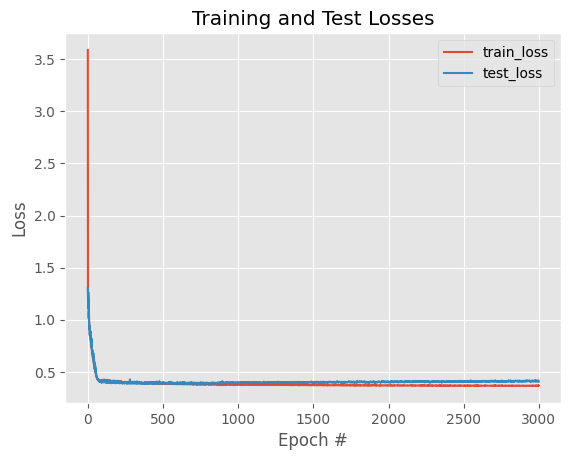

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=512    # training units number
nb_epochs=3000;    # training epochs
temperature = 0.1    # temprature control the smooth of the probabilities


##### Data Augument ##### 
# Add noise
def add_noise(vec):
    deviation = vnoise*random.random()    # generate a random deviation: standard deviation of the normal distribution
    noise = np.random.normal(0, deviation, vec.shape)    # generate random noise based on deviation
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)    # apply add_noise() function to each input for trianing
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)    # generate batches of noisy training data

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)   # "/2"： normalize 0~1

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

# Creates sequential neural network model.
net = Sequential()  
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the siamese neural network
In = Input(shape=(6,1,1))
[Lab1, Lab2] = layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)


dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
dist = layers.Reshape((1,), name='output')(dist)  # reshape the output to be 2D

# ------------------------------------------------------------!!!!!!!!!!
# normalize the dist
dist_normalized = normalize(dist, 0, 2)

# normalize the Lab1 and Lab2
L_min, L_max = 0, 100
a_min, a_max = -128, 127
b_min, b_max = -128, 127

Lab1_flat = Flatten()(Lab1)
Lab2_flat = Flatten()(Lab2)

Lab1_normalized = K.stack([
    normalize(Lab1_flat[:,0], L_min, L_max),
    normalize(Lab1_flat[:,1], a_min, a_max),
    normalize(Lab1_flat[:,2], b_min, b_max)
], axis=-1)

Lab2_normalized = K.stack([
    normalize(Lab2_flat[:,0], L_min, L_max),
    normalize(Lab2_flat[:,1], a_min, a_max),
    normalize(Lab2_flat[:,2], b_min, b_max)
], axis=-1)


# concatenate x1, x2 and dist tensors as the input of softmax layer
con_value = K.concatenate([dist_normalized, Lab1_normalized, Lab2_normalized], axis=-1)

# temprature control: divide by the temperature parameter
con_value = con_value/temperature 

pred = Dense(3, activation="softmax")(con_value)    # add a softmax layer, output a probability distribution over the 3 classes.
# ------------------------------------------------------------!!!!!!!!!!

siamese = Model(inputs = In, outputs = pred)    # create the model: input is the Lab pairs and output is the class

# Loss and optimizer
siamese.compile(loss = categorical_crossentropy, optimizer=Adam(learning_rate=1e-4))    # The categorical_crossentropy loss and the Learning rate set as 1e-4 (Adam)

# Training
H=siamese.fit(X_train, Y_train, batch_size = bs, epochs=nb_epochs, validation_data=(X_val, Y_val))
siamese.evaluate(X_val, Y_val)    


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

## 2.4 Add Hidden Layers before Softmax Layer ##

Epoch 1/1000
70/70 [==============================] - 21s 16ms/step - loss: 0.7285 - val_loss: 0.4696
Epoch 2/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.4842 - val_loss: 0.4503
Epoch 3/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.4717 - val_loss: 0.4372
Epoch 4/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.4666 - val_loss: 0.4616
Epoch 5/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.4655 - val_loss: 0.4390
Epoch 6/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.4628 - val_loss: 0.4297
Epoch 7/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.4556 - val_loss: 0.4411
Epoch 8/1000
70/70 [==============================] - 1s 11ms/step - loss: 0.4534 - val_loss: 0.4369
Epoch 9/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.4516 - val_loss: 0.4200
Epoch 10/1000
70/70 [==============================] - 1s 12ms/step - loss: 0.4470 - val_l

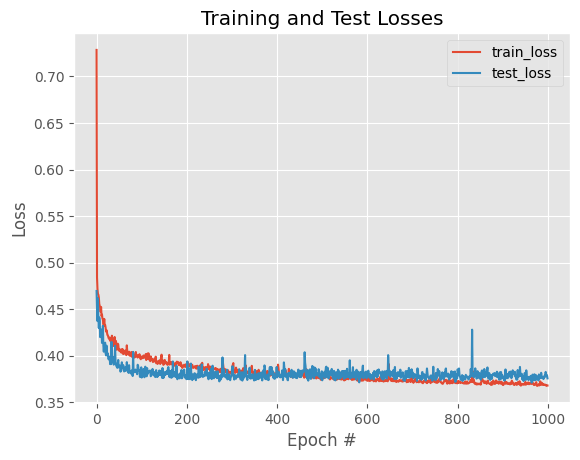

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=512    # training units number
nb_epochs=1000;    # training epochs
temperature = 0.1    # temprature control the smooth of the probabilities


##### Data Augument ##### 
# Add noise
def add_noise(vec):
    deviation = vnoise*random.random()    # generate a random deviation: standard deviation of the normal distribution
    noise = np.random.normal(0, deviation, vec.shape)    # generate random noise based on deviation
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)    # apply add_noise() function to each input for trianing
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)    # generate batches of noisy training data

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)   # "/2"： normalize 0~1

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

# Creates sequential neural network model.
net = Sequential()  
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the siamese neural network
In = Input(shape=(6,1,1))
[Lab1, Lab2] = layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)


dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
dist = layers.Reshape((1,), name='output')(dist)  # reshape the output to be 2D

# ------------------------------------------------------------!!!!!!!!!!
# normalize the dist
dist_normalized = normalize(dist, 0, 2)

# normalize the Lab1 and Lab2
L_min, L_max = 0, 100
a_min, a_max = -128, 127
b_min, b_max = -128, 127

Lab1_flat = Flatten()(Lab1)
Lab2_flat = Flatten()(Lab2)

Lab1_normalized = K.stack([
    normalize(Lab1_flat[:,0], L_min, L_max),
    normalize(Lab1_flat[:,1], a_min, a_max),
    normalize(Lab1_flat[:,2], b_min, b_max)
], axis=-1)

Lab2_normalized = K.stack([
    normalize(Lab2_flat[:,0], L_min, L_max),
    normalize(Lab2_flat[:,1], a_min, a_max),
    normalize(Lab2_flat[:,2], b_min, b_max)
], axis=-1)


# concatenate x1, x2 and dist tensors as the input of softmax layer
con_value = K.concatenate([dist_normalized, Lab1_normalized, Lab2_normalized], axis=-1)

# temprature control: divide by the temperature parameter
con_value = con_value/temperature 

# add layers
x = Dense(32, activation='relu')(con_value)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(3, activation='relu')(x)
x = Dense(3, activation='relu')(x)

pred = Dense(3, activation="softmax")(x)    # add a softmax layer, output a probability distribution over the 3 classes.
# ------------------------------------------------------------!!!!!!!!!!

siamese = Model(inputs = In, outputs = pred)    # create the model: input is the Lab pairs and output is the class

# Loss and optimizer
siamese.compile(loss = categorical_crossentropy, optimizer=Adam(learning_rate=1e-4))    # The categorical_crossentropy loss and the Learning rate set as 1e-4 (Adam)

# Training
H=siamese.fit(X_train, Y_train, batch_size = bs, epochs=nb_epochs, validation_data=(X_val, Y_val))
siamese.evaluate(X_val, Y_val)    


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

##2.5 Only Use Normalization layer ##

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=512    # training units number
nb_epochs=1000;    # training epochs
temperature = 0.1    # temprature control the smooth of the probabilities


##### Data Augument ##### 
# Add noise
def add_noise(vec):
    deviation = vnoise*random.random()    # generate a random deviation: standard deviation of the normal distribution
    noise = np.random.normal(0, deviation, vec.shape)    # generate random noise based on deviation
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)    # apply add_noise() function to each input for trianing
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)    # generate batches of noisy training data

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)   # "/2"： normalize 0~1

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

# Creates sequential neural network model.
net = Sequential()  
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the siamese neural network
In = Input(shape=(6,1,1))
[Lab1, Lab2] = layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)


dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
dist = layers.Reshape((1,), name='output')(dist)  # reshape the output to be 2D

# ------------------------------------------------------------!!!!!!!!!!
# normalize the dist
dist_normalized = normalize(dist, 0, 2)

# normalize the Lab1 and Lab2
L_min, L_max = 0, 100
a_min, a_max = -128, 127
b_min, b_max = -128, 127

Lab1_flat = Flatten()(Lab1)
Lab2_flat = Flatten()(Lab2)

Lab1_normalized = K.stack([
    normalize(Lab1_flat[:,0], L_min, L_max),
    normalize(Lab1_flat[:,1], a_min, a_max),
    normalize(Lab1_flat[:,2], b_min, b_max)
], axis=-1)

Lab2_normalized = K.stack([
    normalize(Lab2_flat[:,0], L_min, L_max),
    normalize(Lab2_flat[:,1], a_min, a_max),
    normalize(Lab2_flat[:,2], b_min, b_max)
], axis=-1)


# concatenate x1, x2 and dist tensors as the input of softmax layer
con_value = K.concatenate([dist_normalized, Lab1_normalized, Lab2_normalized], axis=-1)

# temprature control: divide by the temperature parameter
con_value = con_value/temperature 

# add layers
x = Dense(32, activation='relu')(con_value)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(3, activation='relu')(x)
x = Dense(3, activation='relu')(x)

# replace softmax
x = Dense(3, activation="sigmoid")(x)

# add normalization layer
pred = layers.Lambda(lambda x: x/(K.sum(x)+K.epsilon()))(x)

# ------------------------------------------------------------!!!!!!!!!!

siamese = Model(inputs = In, outputs = pred)    # create the model: input is the Lab pairs and output is the class

# Loss and optimizer
siamese.compile(loss = categorical_crossentropy, optimizer=Adam(learning_rate=1e-4))    # The categorical_crossentropy loss and the Learning rate set as 1e-4 (Adam)

# Training
H=siamese.fit(X_train, Y_train, batch_size = bs, epochs=nb_epochs, validation_data=(X_val, Y_val))
siamese.evaluate(X_val, Y_val)    


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

Epoch 1/1000
70/70 [==============================] - 14s 19ms/step - loss: 1.4827 - val_loss: 1.3541
Epoch 2/1000
70/70 [==============================] - 1s 14ms/step - loss: 1.2777 - val_loss: 1.2333
Epoch 3/1000
70/70 [==============================] - 1s 13ms/step - loss: 1.1930 - val_loss: 1.1648
Epoch 4/1000
70/70 [==============================] - 1s 13ms/step - loss: 1.1234 - val_loss: 1.0910
Epoch 5/1000
70/70 [==============================] - 1s 11ms/step - loss: 1.0781 - val_loss: 1.0653
Epoch 6/1000
70/70 [==============================] - 1s 10ms/step - loss: 1.0549 - val_loss: 1.0371
Epoch 7/1000
70/70 [==============================] - 1s 10ms/step - loss: 1.0255 - val_loss: 1.0046
Epoch 8/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.9815 - val_loss: 0.9389
Epoch 9/1000
70/70 [==============================] - 1s 10ms/step - loss: 0.8841 - val_loss: 0.7842
Epoch 10/1000
70/70 [==============================] - 1s 9ms/step - loss: 0.6941 - val_lo

#3. Data Splitting Test for Euclidean distance loss#
In thie part, the data will be splitted to:
- 3.1 train on one part of the color space and test on an the other part
- 3.2 train on data under 1 light and test on 1 light condition 
- 3.3 train on data under 3 light and test on 1 light condition 
  
In total, 200 color pairs and 4 lights.

##3.1 Train on part of the color space and test on the rest part ##

loss: 0.0094 - val_loss: 0.0064

Epoch 1/500
70/70 [==============================] - 6s 17ms/step - loss: 0.0204 - val_loss: 0.0066
Epoch 2/500
70/70 [==============================] - 1s 8ms/step - loss: 0.0109 - val_loss: 0.0064
Epoch 3/500
70/70 [==============================] - 1s 14ms/step - loss: 0.0108 - val_loss: 0.0063
Epoch 4/500
70/70 [==============================] - 1s 7ms/step - loss: 0.0108 - val_loss: 0.0064
Epoch 5/500
70/70 [==============================] - 1s 8ms/step - loss: 0.0108 - val_loss: 0.0063
Epoch 6/500
70/70 [==============================] - 1s 7ms/step - loss: 0.0107 - val_loss: 0.0063
Epoch 7/500
70/70 [==============================] - 1s 7ms/step - loss: 0.0108 - val_loss: 0.0065
Epoch 8/500
70/70 [==============================] - 1s 8ms/step - loss: 0.0108 - val_loss: 0.0062
Epoch 9/500
70/70 [==============================] - 1s 7ms/step - loss: 0.0107 - val_loss: 0.0062
Epoch 10/500
70/70 [==============================] - 1s 7ms/step - loss: 0.0108 - val_loss: 0.0065
Epoch 1

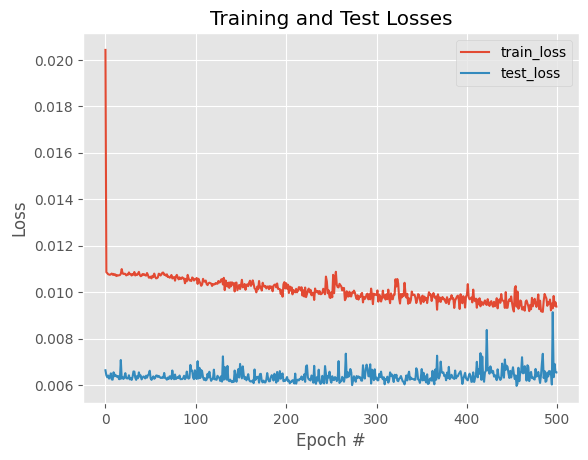

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=512    # training units number set as 256
nb_epochs=500;    # training epochs change to 1000

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

# Randomly choose indices for training and validation
train_indices = random.sample(range(200), k=160)
val_indices = [i for i in range(200) if i not in train_indices]

# Construct the training set
train_data = pd.concat([condition1.iloc[train_indices[0]:train_indices[-1]+1, :],
                        condition2.iloc[train_indices[0]:train_indices[-1]+1, :],
                        condition3.iloc[train_indices[0]:train_indices[-1]+1, :],
                        condition4.iloc[train_indices[0]:train_indices[-1]+1, :]])

# Construct the validation set
val_data = pd.concat([condition1.iloc[val_indices[0]:val_indices[-1]+1, :],
                      condition2.iloc[val_indices[0]:val_indices[-1]+1, :],
                      condition3.iloc[val_indices[0]:val_indices[-1]+1, :],
                      condition4.iloc[val_indices[0]:val_indices[-1]+1, :]])

# Convert to numpy arrays
train_set = np.asarray(train_set).astype(np.float32)
val_set = np.asarray(val_set).astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-4))    # Learning rate changes 1e-5 to 1e-4

# Training
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

##3.2 Train on data under 1 light and test on 1 light condition ##
Randomly choose one lighting condition for testing and the 1 condition for training.

loss: 0.0216 - val_loss: 0.6389  
Significantly higher than naive prediction(0.11)

Epoch 1/1000
25/25 [==============================] - 4s 17ms/step - loss: 2.1460 - val_loss: 1.9866
Epoch 2/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.9185 - val_loss: 1.8915
Epoch 3/1000
25/25 [==============================] - 0s 12ms/step - loss: 1.6983 - val_loss: 1.7905
Epoch 4/1000
25/25 [==============================] - 0s 12ms/step - loss: 1.5107 - val_loss: 1.6821
Epoch 5/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.3406 - val_loss: 1.5765
Epoch 6/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.1806 - val_loss: 1.4711
Epoch 7/1000
25/25 [==============================] - 0s 10ms/step - loss: 1.0238 - val_loss: 1.3734
Epoch 8/1000
25/25 [==============================] - 0s 12ms/step - loss: 0.9355 - val_loss: 1.2910
Epoch 9/1000
25/25 [==============================] - 0s 10ms/step - loss: 0.8394 - val_loss: 1.2137
Epoch 10/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.7574 - val_los

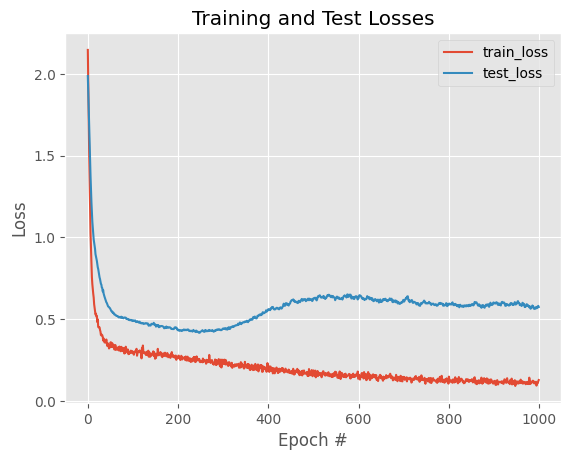

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=256    # training units number set as 256
nb_epochs=1000;    # training epochs change to 1000

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

val_condition = random.choice([condition1, condition2, condition3, condition4])    # randomly choose 1 lighting condition for test set
train_conditions = random.choice([c for c in [condition1, condition2, condition3, condition4] if c is not val_condition])   # randomly choose 1 left condition for training

# Convert to numpy arrays
train_set = train_conditions.values.astype(np.float32)
val_set = val_condition.values.astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=5e-6))    # Learning rate changes 1e-5 to 3e-6

# Training
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

##3.3 Train on data under 3 light and test on 1 light condition ##

###3.3.1 Randomly Choose###
Randomly choose one lighting condition for testing and the left 3 conditions will be conditions for training.

--> 4 fold cross validation...

loss: 0.0301 - val_loss: 0.3302  
Significantly higher than naive prediction(0.11)

Epoch 1/1000
75/75 [==============================] - 4s 9ms/step - loss: 2.0647 - val_loss: 2.1753
Epoch 2/1000
75/75 [==============================] - 1s 7ms/step - loss: 1.9710 - val_loss: 2.1016
Epoch 3/1000
75/75 [==============================] - 1s 7ms/step - loss: 1.8817 - val_loss: 2.0255
Epoch 4/1000
75/75 [==============================] - 1s 7ms/step - loss: 1.7821 - val_loss: 1.9488
Epoch 5/1000
75/75 [==============================] - 1s 8ms/step - loss: 1.6925 - val_loss: 1.8702
Epoch 6/1000
75/75 [==============================] - 1s 9ms/step - loss: 1.5877 - val_loss: 1.7930
Epoch 7/1000
75/75 [==============================] - 1s 9ms/step - loss: 1.4994 - val_loss: 1.7141
Epoch 8/1000
75/75 [==============================] - 1s 9ms/step - loss: 1.4214 - val_loss: 1.6359
Epoch 9/1000
75/75 [==============================] - 1s 6ms/step - loss: 1.3281 - val_loss: 1.5540
Epoch 10/1000
75/75 [==============================] - 1s 7ms/step - loss: 1.2553 - val_loss: 1.4765

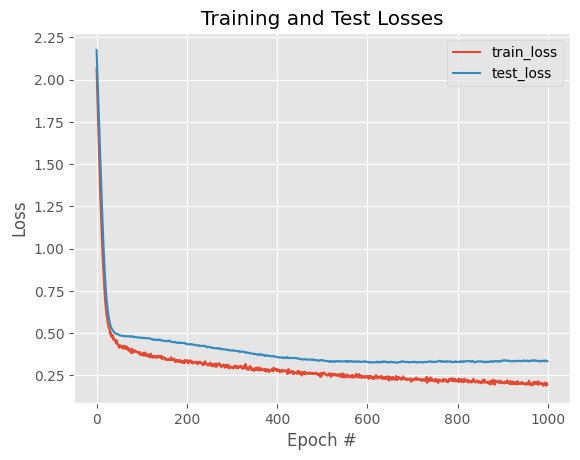

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=256    # training units number set as 256
nb_epochs=1000;    # training epochs change to 1000

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

val_condition = random.choice([condition1, condition2, condition3, condition4])    # randomly choose 1 lighting condition for test set
train_conditions = [c for c in [condition1, condition2, condition3, condition4] if c is not val_condition]    # the left will be train condition
train_set = pd.concat(train_conditions)    # concatenate the remaining conditions for training set

# Convert to numpy arrays
train_set = train_set.values.astype(np.float32)
val_set = val_condition.values.astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-6))    

# Training
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

###3.3.2 1st light condition as test###  

Epoch 1/1000
75/75 [==============================] - 5s 14ms/step - loss: 2.3550 - val_loss: 2.0191
Epoch 2/1000
75/75 [==============================] - 0s 6ms/step - loss: 2.2750 - val_loss: 1.9542
Epoch 3/1000
75/75 [==============================] - 0s 6ms/step - loss: 2.1915 - val_loss: 1.8874
Epoch 4/1000
75/75 [==============================] - 1s 7ms/step - loss: 2.0953 - val_loss: 1.8175
Epoch 5/1000
75/75 [==============================] - 1s 7ms/step - loss: 2.0067 - val_loss: 1.7481
Epoch 6/1000
75/75 [==============================] - 0s 7ms/step - loss: 1.9132 - val_loss: 1.6802
Epoch 7/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.8134 - val_loss: 1.6119
Epoch 8/1000
75/75 [==============================] - 1s 7ms/step - loss: 1.7214 - val_loss: 1.5435
Epoch 9/1000
75/75 [==============================] - 1s 7ms/step - loss: 1.6284 - val_loss: 1.4777
Epoch 10/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.5361 - val_loss: 1.412

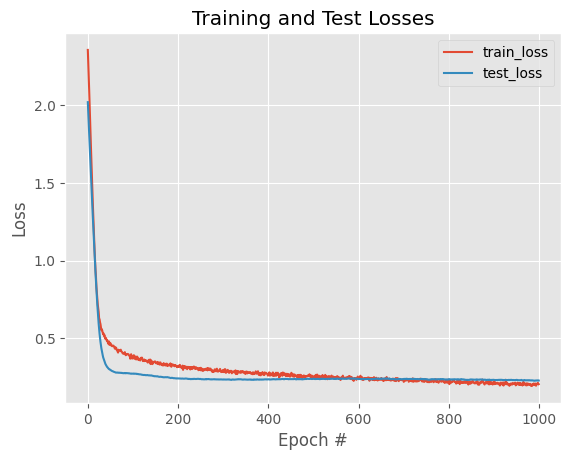

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=256    # training units number
nb_epochs=1000;    # training epochs change

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

val_condition = condition1   # choose 1st lighting condition for test set
train_conditions = [c for c in [condition1, condition2, condition3, condition4] if c is not val_condition]    # the left will be train condition
train_set = pd.concat(train_conditions)    # concatenate the remaining conditions for training set

# Convert to numpy arrays
train_set = train_set.values.astype(np.float32)
val_set = val_condition.values.astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-6))    

# Training
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

###3.3.3 2nd light condition as test###  

Epoch 1/1000
75/75 [==============================] - 4s 9ms/step - loss: 2.2083 - val_loss: 2.1821
Epoch 2/1000
75/75 [==============================] - 0s 6ms/step - loss: 2.1285 - val_loss: 2.1126
Epoch 3/1000
75/75 [==============================] - 0s 6ms/step - loss: 2.0406 - val_loss: 2.0435
Epoch 4/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.9568 - val_loss: 1.9753
Epoch 5/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.8722 - val_loss: 1.9028
Epoch 6/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.7833 - val_loss: 1.8279
Epoch 7/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.6937 - val_loss: 1.7510
Epoch 8/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.6137 - val_loss: 1.6727
Epoch 9/1000
75/75 [==============================] - 1s 7ms/step - loss: 1.5224 - val_loss: 1.5935
Epoch 10/1000
75/75 [==============================] - 0s 6ms/step - loss: 1.4349 - val_loss: 1.5153

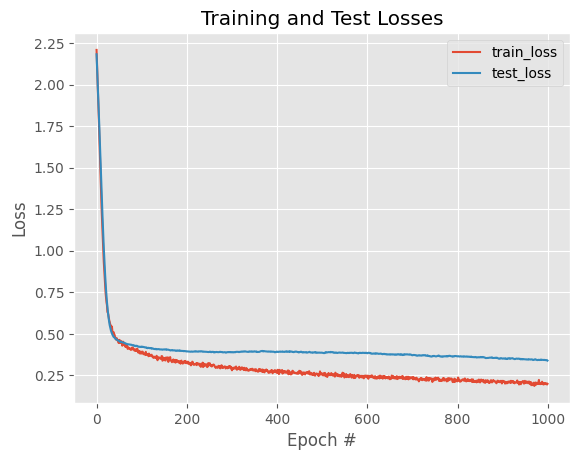

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=256    # training units number
nb_epochs=1000;    # training epochs change

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

val_condition = condition2   # choose 2nd lighting condition for test set

train_conditions = [c for c in [condition1, condition2, condition3, condition4] if c is not val_condition]    # the left will be train condition
train_set = pd.concat(train_conditions)    # concatenate the remaining conditions for training set

# Convert to numpy arrays
train_set = train_set.values.astype(np.float32)
val_set = val_condition.values.astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-6))    

# Training
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

###3.3.4 3rd light condition as test###  

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=256    # training units number
nb_epochs=1000;    # training epochs change

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

val_condition = condition3   # choose 3rd lighting condition for test set

train_conditions = [c for c in [condition1, condition2, condition3, condition4] if c is not val_condition]    # the left will be train condition
train_set = pd.concat(train_conditions)    # concatenate the remaining conditions for training set

# Convert to numpy arrays
train_set = train_set.values.astype(np.float32)
val_set = val_condition.values.astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-6))    

# Training
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

###3.3.5 4th light condition as test###  

In [ ]:
bs=8    # batch_size  
vnoise=1    # the amount of noise to be added to training data
nn=256    # training units number
nb_epochs=1000;    # training epochs change

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/BVG_DM.csv', delimiter=';', header=0)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

val_condition = condition4   # choose 4th lighting condition for test set
train_conditions = [c for c in [condition1, condition2, condition3, condition4] if c is not val_condition]    # the left will be train condition
train_set = pd.concat(train_conditions)    # concatenate the remaining conditions for training set

# Convert to numpy arrays
train_set = train_set.values.astype(np.float32)
val_set = val_condition.values.astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Create the twin Network 
net = Sequential()
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the Siamese network
In = Input(shape=(6,1,1))
[Lab1,Lab2]=layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)
dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
siamese = Model(inputs=In, outputs=dist)

# Loss and optimizer
#datagen_train.fit(X_train)
siamese.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=1e-6))    

# Training
H=siamese.fit(train_generator, epochs=nb_epochs, validation_data=(X_val, Y_val), verbose=1)
siamese.evaluate(X_val,Y_val)


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

#4. Data Splitting Test for Possibilty Distribution#  
In thie part, the data will be splitted to:
- 4.1 train on one part of the color space and test on an the other part
- 4.2 train on data under 3 light and test on 1 light condition 
  
In total, 200 color pairs and 4 lights.

## 4.1 Train on part of the color space and test on the rest part ##


In [ ]:
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/all_BVG.csv', header=0)    # note the data is from all_BVG.csv file

# Calculate the most selected data by participants
results_cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'];
results_subset = data_df.loc[:, results_cols]    # select columns of participants evaluation result

# count occurrences in each row, and make new columns
def count_occurrences(row,element):
    count = 0
    for value in row:
        if value == element:
            count += 1
    return count/20

data_df['0occurrences'] = results_subset.apply(count_occurrences, args=(0,), axis=1)
data_df['1occurrences'] = results_subset.apply(count_occurrences, args=(1,), axis=1)
data_df['2occurrences'] = results_subset.apply(count_occurrences, args=(2,), axis=1)


# Data splitting(7:3)
data_df = data_df.drop(columns = ['C1', 'C2']+results_cols)    # drop columns (color information and results of participants)
train_df, val_df = train_test_split(data_df, test_size=0.3, random_state=42)    # split the data   
train_set = train_df.values
val_set = val_df.values

# Get the Lab data (X) and probability distribution (Y)
train_set = np.asarray(train_set).astype(np.float32)    # convert to ndarray, then convert all the components to float32
X_train = train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train = train_set[:,6:9]    # probability distribution columns
Y_train = Y_train.reshape(-1,3)

val_set = np.asarray(val_set).astype(np.float32)
X_val = val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val = val_set[:,6:9]
Y_val = Y_val.reshape(-1,3)
print(Y_val)  # example: output to see the possibility distribution for validation set

In [ ]:
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy

##### Preprocess Train/Test Sets ##### 
data_df = pd.read_csv('/content/drive/MyDrive/data/all_BVG.csv', header=0)    # note the data is from all_BVG.csv file

# Calculate the most selected data by participants
results_cols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'];
results_subset = data_df.loc[:, results_cols]    # select columns of participants evaluation result

# count occurrences in each row, and make new columns
def count_occurrences(row,element):
    count = 0
    for value in row:
        if value == element:
            count += 1
    return count/20

data_df['0occurrences'] = results_subset.apply(count_occurrences, args=(0,), axis=1)
data_df['1occurrences'] = results_subset.apply(count_occurrences, args=(1,), axis=1)
data_df['2occurrences'] = results_subset.apply(count_occurrences, args=(2,), axis=1)

# Extract data for each lighting condition
condition1 = data_df.iloc[0:200, :]
condition2 = data_df.iloc[200:400, :]
condition3 = data_df.iloc[400:600, :]
condition4 = data_df.iloc[600:800, :]

# Randomly choose indices for training and validation
train_indices = random.sample(range(200), k=160)
val_indices = [i for i in range(200) if i not in train_indices]

# Construct the training set
train_data = pd.concat([condition1.iloc[train_indices[0]:train_indices[-1]+1, :],
                        condition2.iloc[train_indices[0]:train_indices[-1]+1, :],
                        condition3.iloc[train_indices[0]:train_indices[-1]+1, :],
                        condition4.iloc[train_indices[0]:train_indices[-1]+1, :]])

# Construct the test set
val_data = pd.concat([condition1.iloc[val_indices[0]:val_indices[-1]+1, :],
                      condition2.iloc[val_indices[0]:val_indices[-1]+1, :],
                      condition3.iloc[val_indices[0]:val_indices[-1]+1, :],
                      condition4.iloc[val_indices[0]:val_indices[-1]+1, :]])

# Convert to numpy arrays
train_set = np.asarray(train_set).astype(np.float32)
val_set = np.asarray(val_set).astype(np.float32)

X_train=train_set[:,0:6]
X_train = X_train.reshape(-1,6,1,1)
Y_train=train_set[:,6]

X_val =val_set[:,0:6]
X_val = X_val.reshape(-1,6,1,1)
Y_val =val_set[:,6]


##### Data augmentation #####
def add_noise(vec):
    deviation = vnoise*random.random()
    noise = np.random.normal(0, deviation, vec.shape)
    vec += noise
    return vec

# Prepare data-augmenting data generator
datagen_train = ImageDataGenerator(preprocessing_function=add_noise)
train_generator = datagen_train.flow(X_train, Y_train, shuffle=True, batch_size=bs)
#datagen_val = ImageDataGenerator()


##### Neural Network #####
# Calculate the euclidean distance between two vectors
def euclidean_distance(vec):
    x1, x2 = vec
    return K.sqrt(K.sum(K.square(x1 - x2), axis=-1)+1e-16)   # "/2"： normalize 0~1

# Split the input into two parts (Lab1 and Lab2)
def split(x):
    return [x[:,0:3,:,:],x[:,3:6,:,:]]

# Normalize data by using min-max normalization
def normalize(data, min_value, max_value):
    return (data-min_value)/(max_value-min_value)

# Creates sequential neural network model.
net = Sequential()  
net.add(Flatten())
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))    
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))
net.add(Dense(nn, activation='relu'))

# Create the siamese neural network
In = Input(shape=(6,1,1))
[Lab1, Lab2] = layers.Lambda(split)(In)    # split the input into two parts
x1 = net(Lab1)
x2 = net(Lab2)


dist = layers.Lambda(euclidean_distance)([x1,x2])    # calculate the euclidean distance between the output
dist = layers.Reshape((1,), name='output')(dist)  # reshape the output to be 2D

# ------------------------------------------------------------!!!!!!!!!!
# normalize the dist
dist_normalized = normalize(dist, 0, 2)

# normalize the Lab1 and Lab2
L_min, L_max = 0, 100
a_min, a_max = -128, 127
b_min, b_max = -128, 127

Lab1_flat = Flatten()(Lab1)
Lab2_flat = Flatten()(Lab2)

Lab1_normalized = K.stack([
    normalize(Lab1_flat[:,0], L_min, L_max),
    normalize(Lab1_flat[:,1], a_min, a_max),
    normalize(Lab1_flat[:,2], b_min, b_max)
], axis=-1)

Lab2_normalized = K.stack([
    normalize(Lab2_flat[:,0], L_min, L_max),
    normalize(Lab2_flat[:,1], a_min, a_max),
    normalize(Lab2_flat[:,2], b_min, b_max)
], axis=-1)


# concatenate x1, x2 and dist tensors as the input of softmax layer
con_value = K.concatenate([dist_normalized, Lab1_normalized, Lab2_normalized], axis=-1)

# temprature control: divide by the temperature parameter
con_value = con_value/temperature 

# add layers
x = Dense(32, activation='relu')(con_value)
x = Dense(32, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(16, activation='relu')(x)
x = Dense(3, activation='relu')(x)
x = Dense(3, activation='relu')(x)

pred = Dense(3, activation="softmax")(x)    # add a softmax layer, output a probability distribution over the 3 classes.
# ------------------------------------------------------------!!!!!!!!!!

siamese = Model(inputs = In, outputs = pred)    # create the model: input is the Lab pairs and output is the class

# Loss and optimizer
siamese.compile(loss = categorical_crossentropy, optimizer=Adam(learning_rate=1e-4))    # The categorical_crossentropy loss and the Learning rate set as 1e-4 (Adam)

# Training
H=siamese.fit(X_train, Y_train, batch_size = bs, epochs=nb_epochs, validation_data=(X_val, Y_val))
siamese.evaluate(X_val, Y_val)    


##### Plot the curves #####
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

predictions = siamese.predict(x=X_val)
N = np.arange(0, nb_epochs)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="test_loss")
plt.title("Training and Test Losses")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

Epoch 1/1000


ValueError: ignored